In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Load data:

In [3]:
d, Nobs = 50_000, 40_000
X = sprandn(d, Nobs, 2e-2)
X[1,:] = ones(Nobs)
nz = 250
ξ_true = spzeros(d)
ξ_true[1] = 3*rand()
nzind = sample(1:d, nz)
ξ_true[nzind[1:Int(nz/2)]] = rand(Uniform(5,10),Int(nz/2))
ξ_true[nzind[Int(nz/2)+1:end]] = -rand(Uniform(5,10),Int(nz/2));
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

#### Define prior:

In [4]:
σ02 = 1
prior = SS_prior(d, σ02);

#### Define model:

In [5]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

#### Define minibatch sampler:

In [6]:
mb_size = 100
prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)

@showprogress for i in 2:d
    weights_het = abs.(X[i,:])./sum(abs.(X[i,:]))
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:05:19


#### Define output scheduler:

In [9]:
k = 1
A_xi = spzeros(k,d)
for i in 1:k 
    A_xi[i,i] = 1.
end

In [10]:
bb_fixed = linear_bound(my_model.ll, my_model.pr, gs_list)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:54


linear_bound([40000.0, 649.571, 623.633, 625.37, 658.705, 649.491, 603.37, 589.003, 646.627, 666.471  …  667.739, 672.511, 649.268, 629.564, 634.713, 643.713, 638.925, 657.068, 634.018, 657.725], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [15]:
A_hyp = ones(1,hyperparam_size(prior))/hyperparam_size(prior)

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(6*10^7, 2*10^7)
outp = outputscheduler(opf,opt)
bb = deepcopy(bb_fixed)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

#### Define mbsampler + block Gibbs sampler list:

In [16]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e5)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [17]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10% attempts in 516.85 mins 
20% attempts in 1023.49 mins 
30% attempts in 1508.78 mins 
Trimmed after 20000000 bouncing attempts 
40% attempts in 1982.53 mins 
50% attempts in 2462.14 mins 
60% attempts in 2934.73 mins 
70% attempts in 3399.68 mins 
80% attempts in 3861.05 mins 
90% attempts in 4315.91 mins 
100% attempts in 4764.57 mins 


* Number of bounces:

In [18]:
zz_bounces = sum(mstate.n_bounces)
hyp_bounces = outp.opf.tot_bounces-sum(mstate.n_bounces)
@printf("ZZ total bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ total bounces: 2157586, hyper bounces: 173454

In [19]:
size(outp.opf.xi_skeleton,2)/outp.opt.max_attempts

0.02121305

In [21]:
post_mean_gzz = mstate.mu
# post_median_gzz = median(xi_samples,2);

### Credible intervals:

In [22]:
xi_sd = sqrt.(outp.opf.xi_m2 - outp.opf.xi_mu.^2)
ci = zeros(d,2)
ci[:,1] = outp.opf.xi_mu-3*xi_sd
ci[:,2] = outp.opf.xi_mu+3*xi_sd;

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

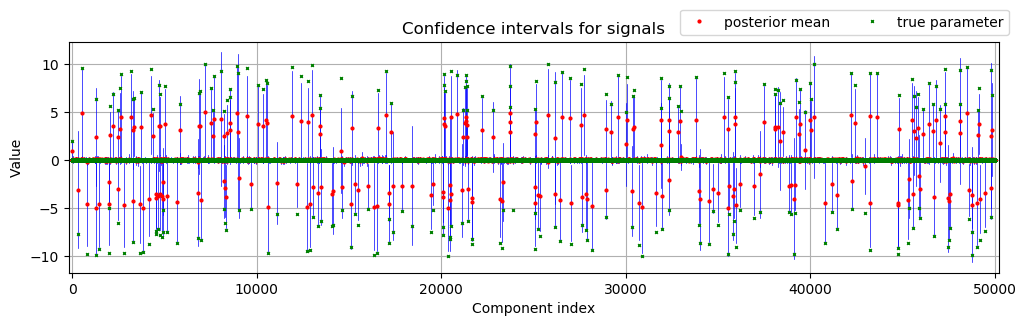

Progress: 100%|█████████████████████████████████████████| Time: 0:16:01


In [26]:
fig = figure(figsize=(12,3))
@showprogress for i in 1:d
    plot([i,i], ci[i,:], "b-", lw=0.5)
end
plot(1:d, outp.opf.xi_mu, "ro", markersize=2, label="posterior mean");
plot(1:d, ξ_true, "gx", markersize=2, label="true parameter")
grid(true)
xlim(-200,d+200)
xlabel("Component index")
ylabel("Value")
title("Confidence intervals for signals")
legend(ncol=2,bbox_to_anchor=(0.65, 1))
savefig("plots/CId50K.pdf", format="pdf", dpi=10000, bbox_inches="tight")

In [24]:
save("/home/postdoc/dsen/Desktop/GZZ_data/data/opf_d50K.jld", "opf", outp.opf, "X", X, "y", y, "xi_true", ξ_true)